In [42]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
from dataclasses import dataclass

WDIR = os.environ['DM21CM_DIR']
sys.path.append(WDIR)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file(f'{WDIR}/matplotlibrc')

from matplotlib.transforms import Affine2D
from matplotlib.colors import Normalize

from PIL import Image
import glob

In [85]:
@dataclass
class PlotConfig:
    k: str
    i_arr: list
    cmap: str
    drange: tuple

def normalize_to_range(arr, vmin, vmax):
    return (arr - vmin) / (vmax - vmin)

# def remove_white_pixels(image):
#     img = image.convert("RGBA")
#     data = img.getdata()
#     newData = [(r, g, b, 0) if np.sqrt((r-255)**2+(g-255)**2+(b-255)**2) < 10 else (r, g, b, a) for r, g, b, a in data]
#     img.putdata(newData)
#     return img

def is_white(rgba):
    return np.sqrt((rgba[0]-255)**2+(rgba[1]-255)**2+(rgba[2]-255)**2) < 10

def remove_edge_white_pixels(image):
    img = image.convert("RGBA")
    data = np.array(img)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if is_white(data[i,j]):
                data[i,j] = [0., 0., 0., 0.]
            else:
                break
        for j in range(data.shape[1]-1, -1, -1):
            if is_white(data[i,j]):
                data[i,j] = [0., 0., 0., 0.]
            else:
                break
    return Image.fromarray(data)

def crop_transparent(image):
    image_data = np.array(image)
    non_empty_columns = np.where(image_data.max(axis=0)[:, 3] > 0)[0]
    non_empty_rows = np.where(image_data.max(axis=1)[:, 3] > 0)[0]
    cropBox = (min(non_empty_rows), max(non_empty_rows), min(non_empty_columns), max(non_empty_columns))
    image_data_new = image_data[cropBox[0]:cropBox[1]+1, cropBox[2]:cropBox[3]+1 , :]
    return Image.fromarray(image_data_new)

In [3]:
run_data = np.load(f"plot_records.npy", allow_pickle=True).item()

In [4]:
configs = [
    PlotConfig('delta_slice', [130, 140], 'binary', (-0.5, 1.0)),
    PlotConfig('T_k_slice',   [130, 140], 'plasma', (3., 10.)),
    PlotConfig('x_H_slice',   [130, 140], 'viridis', (0., 1.)),
    PlotConfig('dep_heat_slice', [130], 'Reds', (0., 1.)),
    PlotConfig('dep_ion_slice', [130], 'Greens', (0., 0.5)),
    PlotConfig('dep_exc_slice', [130], 'Purples', (0., 0.3)),
]

In [ ]:
for c in configs:
    n_max = 32
    for i in c.i_arr:
        data = run_data[c.k][i][:n_max, :n_max].copy()
        tot_dep = run_data['dep_heat_slice'][i][:n_max, :n_max] \
                + run_data['dep_ion_slice'][i][:n_max, :n_max] \
                + run_data['dep_exc_slice'][i][:n_max, :n_max]
        tot_dep = np.mean(tot_dep)
        if c.k == 'x_H_slice':
            data = 1 - data
        if c.k.startswith('dep'):
            data /= tot_dep
        data = normalize_to_range(data, *c.drange)

        fig, ax = plt.subplots()
        im = ax.imshow(data, interpolation='none', cmap=c.cmap, origin='lower', vmin=0, vmax=1)
        transform = Affine2D().scale(1, 0.3).skew_deg(45, 0) + ax.transData
        im.set_transform(transform)
        ax.set(xlim=(-1,1+int(n_max*1.3)), ylim=(-1,1+int(n_max*0.3)))
        ax.axis('off')
        fig.savefig(f"{WDIR}/plotting/pipeline/plots/{c.k}-{i}.png", bbox_inches='tight')

In [51]:
np.min(get_xray_slice(130)), np.max(get_xray_slice(130))

(0.6279696091553402, 1.7451024507707762)

In [ ]:
import h5py
from dm21cm.evolve import get_z_edges

z_edges = get_z_edges(45, 5, 1.01)

def get_xray_slice(i):
    k = f"z{z_edges[i]:.3f}_z{z_edges[i+1]:.3f}"
    with h5py.File("xray_box_cache.h5", 'r') as hf:
        data = np.fft.irfftn(hf[k][()])
    return data[10]

vmins = [-0.2, 0.0, 0.2, 0.4]

for i, vmin in zip([60, 100, 140, 180], vmins):
    data = get_xray_slice(i)

    fig, ax = plt.subplots()
    im = ax.imshow(data, interpolation='none', cmap='Blues_r', origin='lower', vmin=vmin, vmax=2.)
    transform = Affine2D().scale(1, 0.3).skew_deg(45, 0) + ax.transData
    im.set_transform(transform)
    ax.set(xlim=(-1,1+int(n_max*1.3)), ylim=(-1,1+int(n_max*0.3)))
    ax.axis('off')
    fig.savefig(f"{WDIR}/plotting/pipeline/plots/xray-{i}.png", bbox_inches='tight')

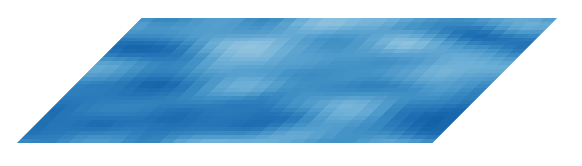

In [90]:
from dm21cm.xray_cache import XrayCache
xc = XrayCache('.', 32, 2)

def get_smoothed_xray_slice(i):
    k = f"z{z_edges[i]:.3f}_z{z_edges[i+1]:.3f}"
    with h5py.File("xray_box_cache.h5", 'r') as hf:
        ftbox = hf[k][()]
    return xc.smooth_box(ftbox, 0, 6)[10]

i = 180
data = get_smoothed_xray_slice(i)

fig, ax = plt.subplots()
im = ax.imshow(data, interpolation='none', cmap='Blues_r', origin='lower', vmin=0.4, vmax=2.)
transform = Affine2D().scale(1, 0.3).skew_deg(45, 0) + ax.transData
im.set_transform(transform)
ax.set(xlim=(-1,1+int(n_max*1.3)), ylim=(-1,1+int(n_max*0.3)))
ax.axis('off')
fig.savefig(f"{WDIR}/plotting/pipeline/plots/xraysmoothed-{i}.png", bbox_inches='tight')

In [86]:
plot_dir = f"{WDIR}/plotting/pipeline/plots"
fns = [f for f in glob.glob(f"{plot_dir}/*.png") if 'cropped' not in f]
for fn in fns:
    save_fn = f"{fn.split('.png')[0]}_cropped.png"
    original_image = Image.open(fn)
    no_white_image = remove_edge_white_pixels(original_image)
    cropped_image = crop_transparent(no_white_image)
    cropped_image.save(save_fn)

## fake data

In [ ]:
for cmap in ['binary', 'plasma', 'magma', 'viridis', 'Blues', 'Reds', 'Greens', 'Purples']:
    N = 10
    data = np.random.rand(N, N)
    norm = Normalize(-0.4, 1.4, clip=False)

    fig, ax = plt.subplots()
    im = ax.imshow(data, interpolation='none', cmap=cmap, origin='lower', norm=norm)
    transform = Affine2D().scale(1, 0.3).skew_deg(45, 0) + ax.transData
    im.set_transform(transform)
    ax.set(xlim=(-1,13), ylim=(-1,4))
    ax.axis('off')
    fig.savefig(f"../plots/pipeline_diagram/{cmap}.png", bbox_inches='tight')